# 학습 목표

1. 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해 볼 수 있다.
2. 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출할 수 있다.
3. 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아볼 수 있다.
4. Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올릴 수 있다.

# kaggle - 2nd ML : house price prediction로 연습하기


- kaggle 가입 후 대회 파악 ex) 데이터 형식, 점수평가 기준, baseline code 등등
- 데이터, 라이브러리 가져오기
- 데이터 이해하기
- 모델 설계
- 결과 제출
- 성능 향상을 위한 하이퍼 파라미터 튜닝

In [47]:
# 1. baseline code 돌려보기
#conda install -c conda-forge xgboost=1.4.2
#conda install -c conda-forge lightgbm=3.3.0
#conda install -c conda-forge missingno=0.5.0


#라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [48]:
#파일 경로 지정

data_dir = "~/aiffel/kaggle_kakr_housing/data"
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

~/aiffel/kaggle_kakr_housing/data/train.csv
~/aiffel/kaggle_kakr_housing/data/test.csv


# 데이터 전처리 : 데이터 이해하기

In [49]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [50]:
# 학습데이터에서 라벨 제거하기
y = data['price']
del data['price']

In [51]:
print(data.columns)
print("---------------")
print(y)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
---------------
0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


## train + sub data : 전체 데이터를 보기 위함

In [52]:
#나중에 train으로 나눌 때 index로 사용
train_len = len(data)
#전체 데이터
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [53]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 각 변수별 결측 유무 판단 - missingno라이브러리의 matrix함수

만약 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나온다. 결측치가 없다면 매트릭스 전체가 까맣게 나온다.

<AxesSubplot:>

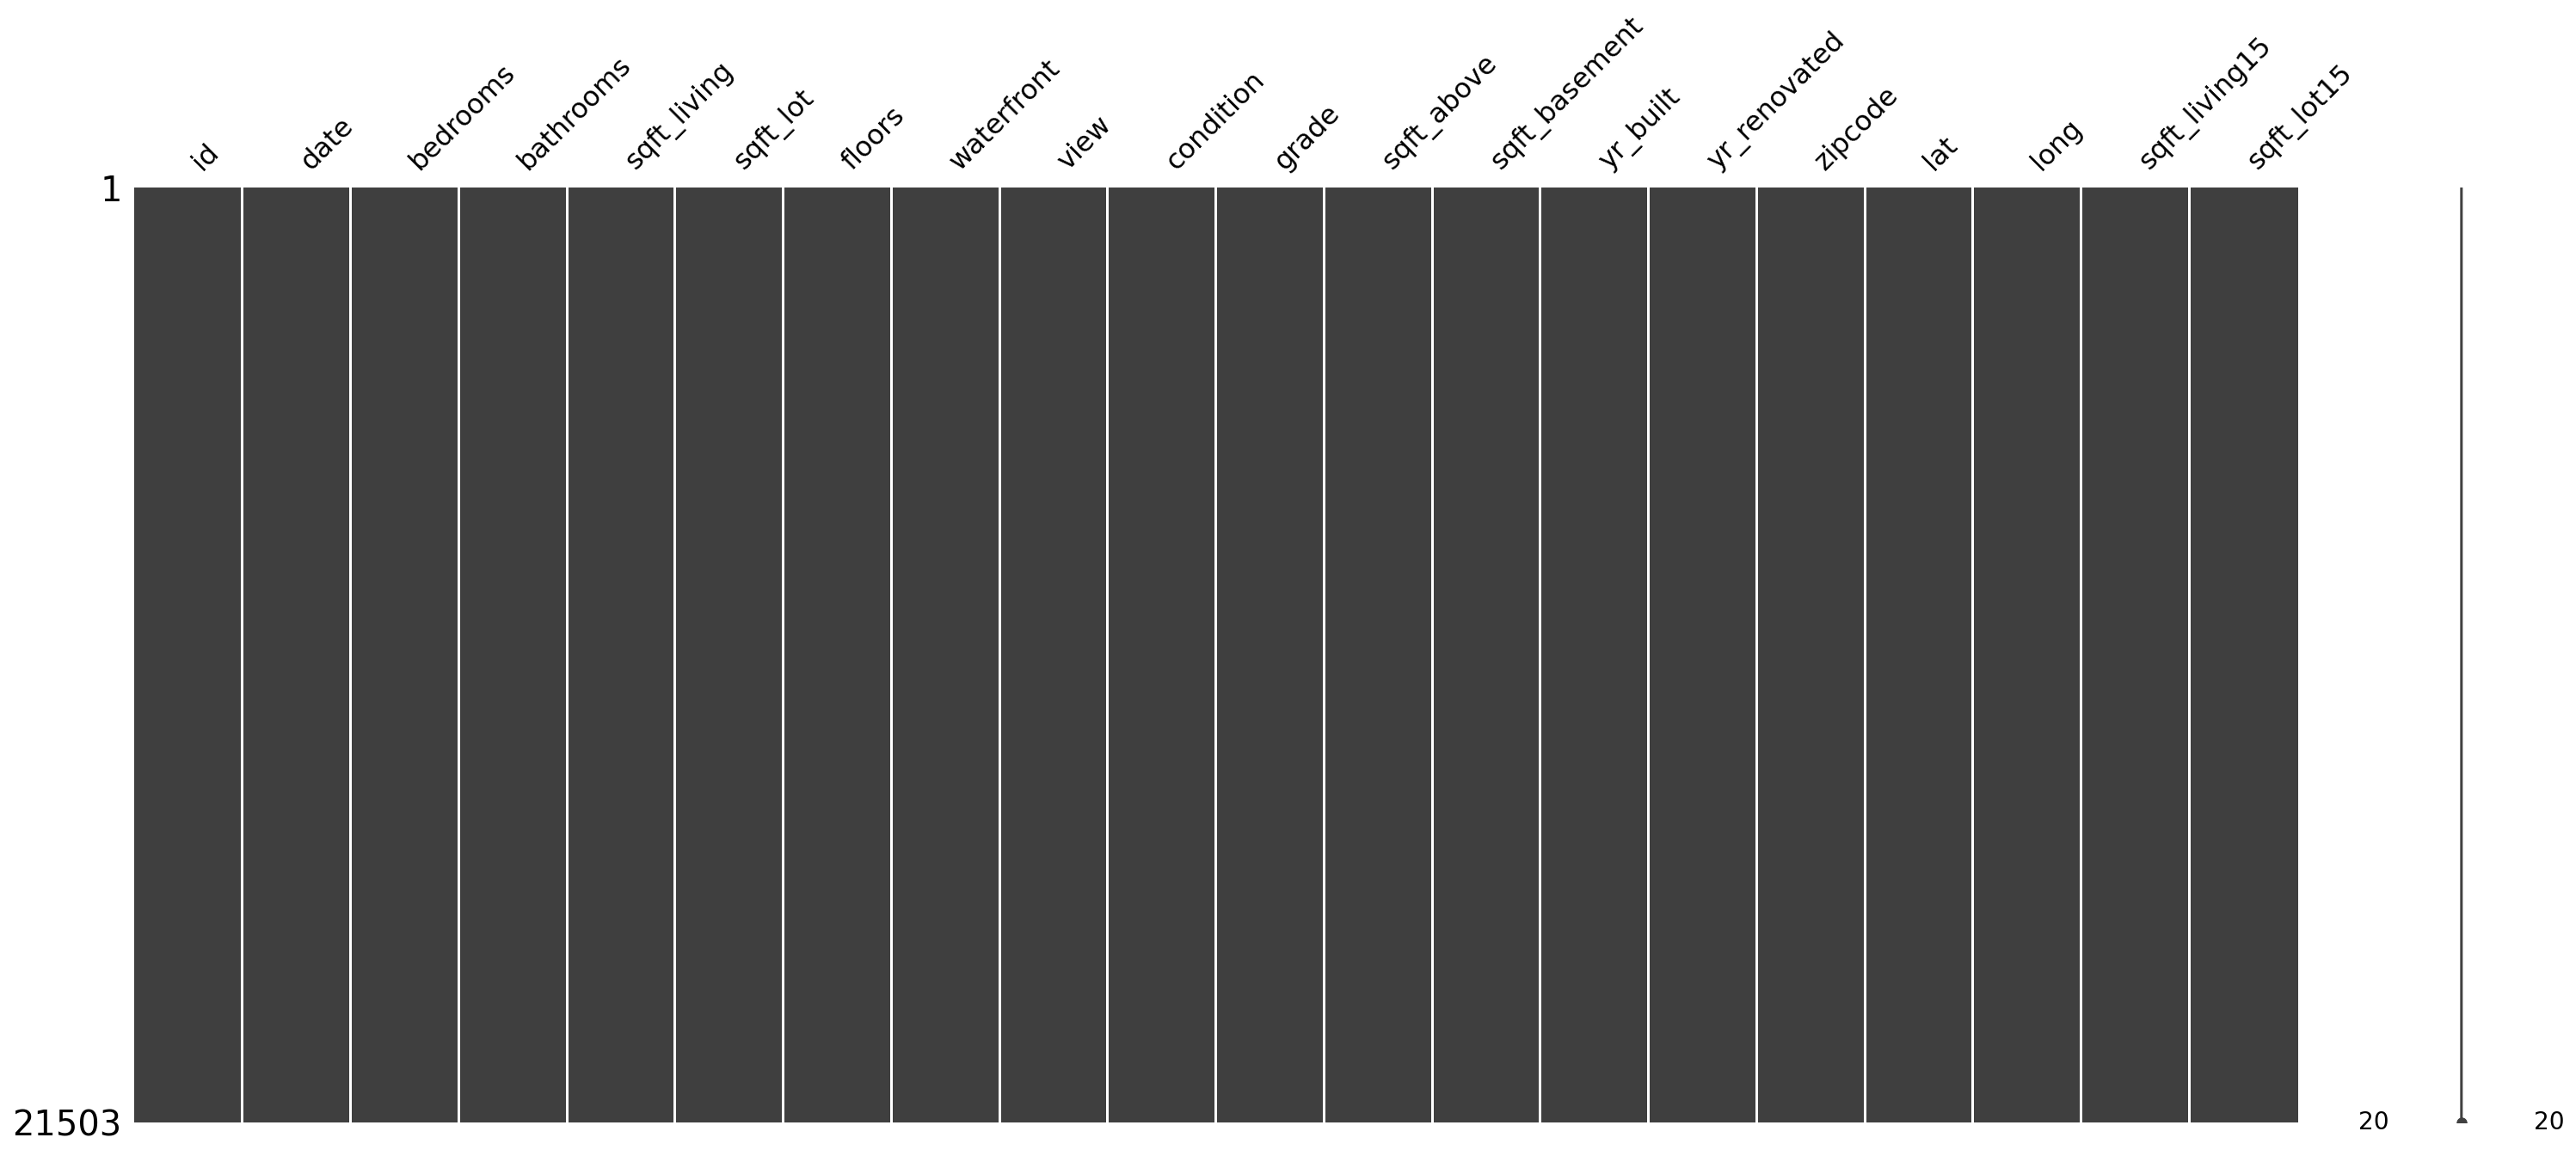

In [54]:
msno.matrix(data) #결측치가 없다고 판단.

## 결측치 확인 작업 : id column

In [55]:
# 1. id 컬럼이 결측치인지 확인한다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [56]:
# 2. 결측치인 데이터만 뽑아내기.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [57]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [58]:
# 전체 데어터의 각 컬럼에 대해서 결측치를 확인하는 코드를 for문으로 작성

for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## 칼럼 제거 or 수정

유의할 것: 제거의 경우 나중에 사용할 수 있기 때문에 복사를 해둘 것

In [59]:
#아이디 칼럼 복사해두기
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [60]:
# date column에서 연/월까지만 표시
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 각 변수들의 분포 확인하기
### 커널 밀도 함수로 분포를 확인 : seaborn - kdeplot함수 

- 전체 그래프를 그려보기
- skewed됐는지 아닌지 파악하기
- skewed됐으면 log-scaling

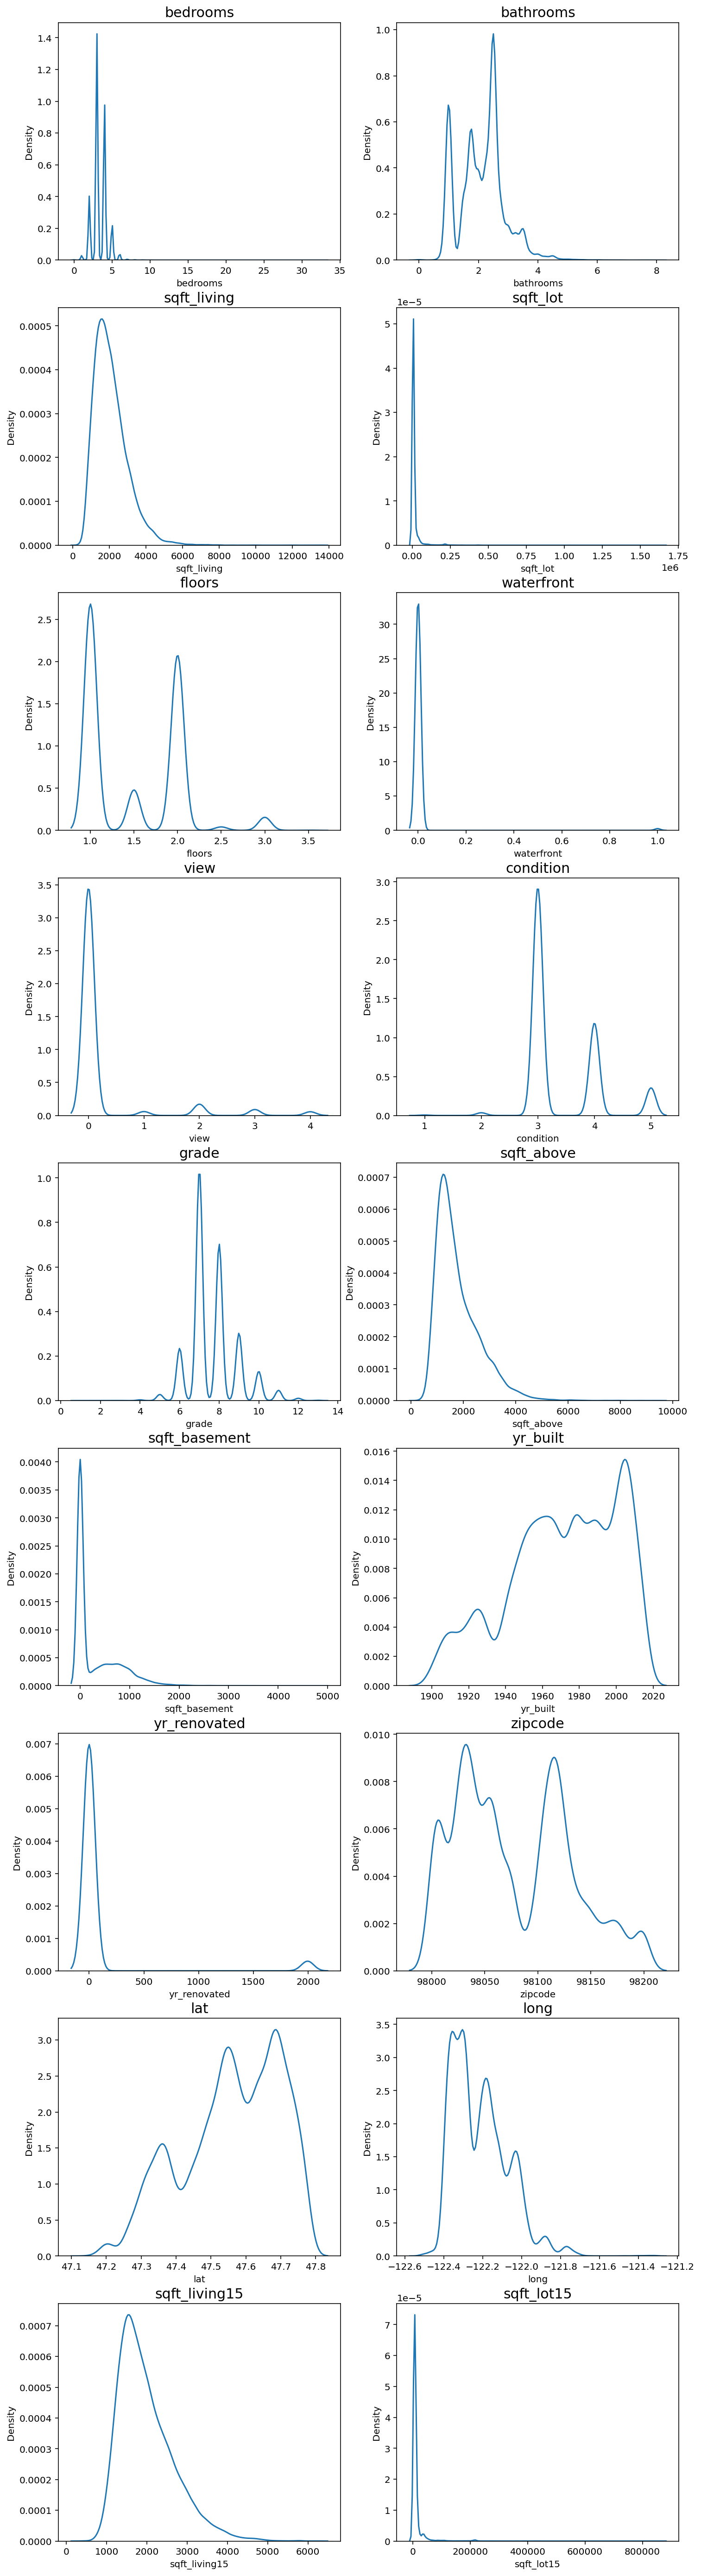

In [61]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id, date변수를 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        # 18개 column의 분포를 보여주고 for문 탈출
        if count == 19 :
            break

In [62]:
# 치우쳐진 분포를 로그스케일링 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)


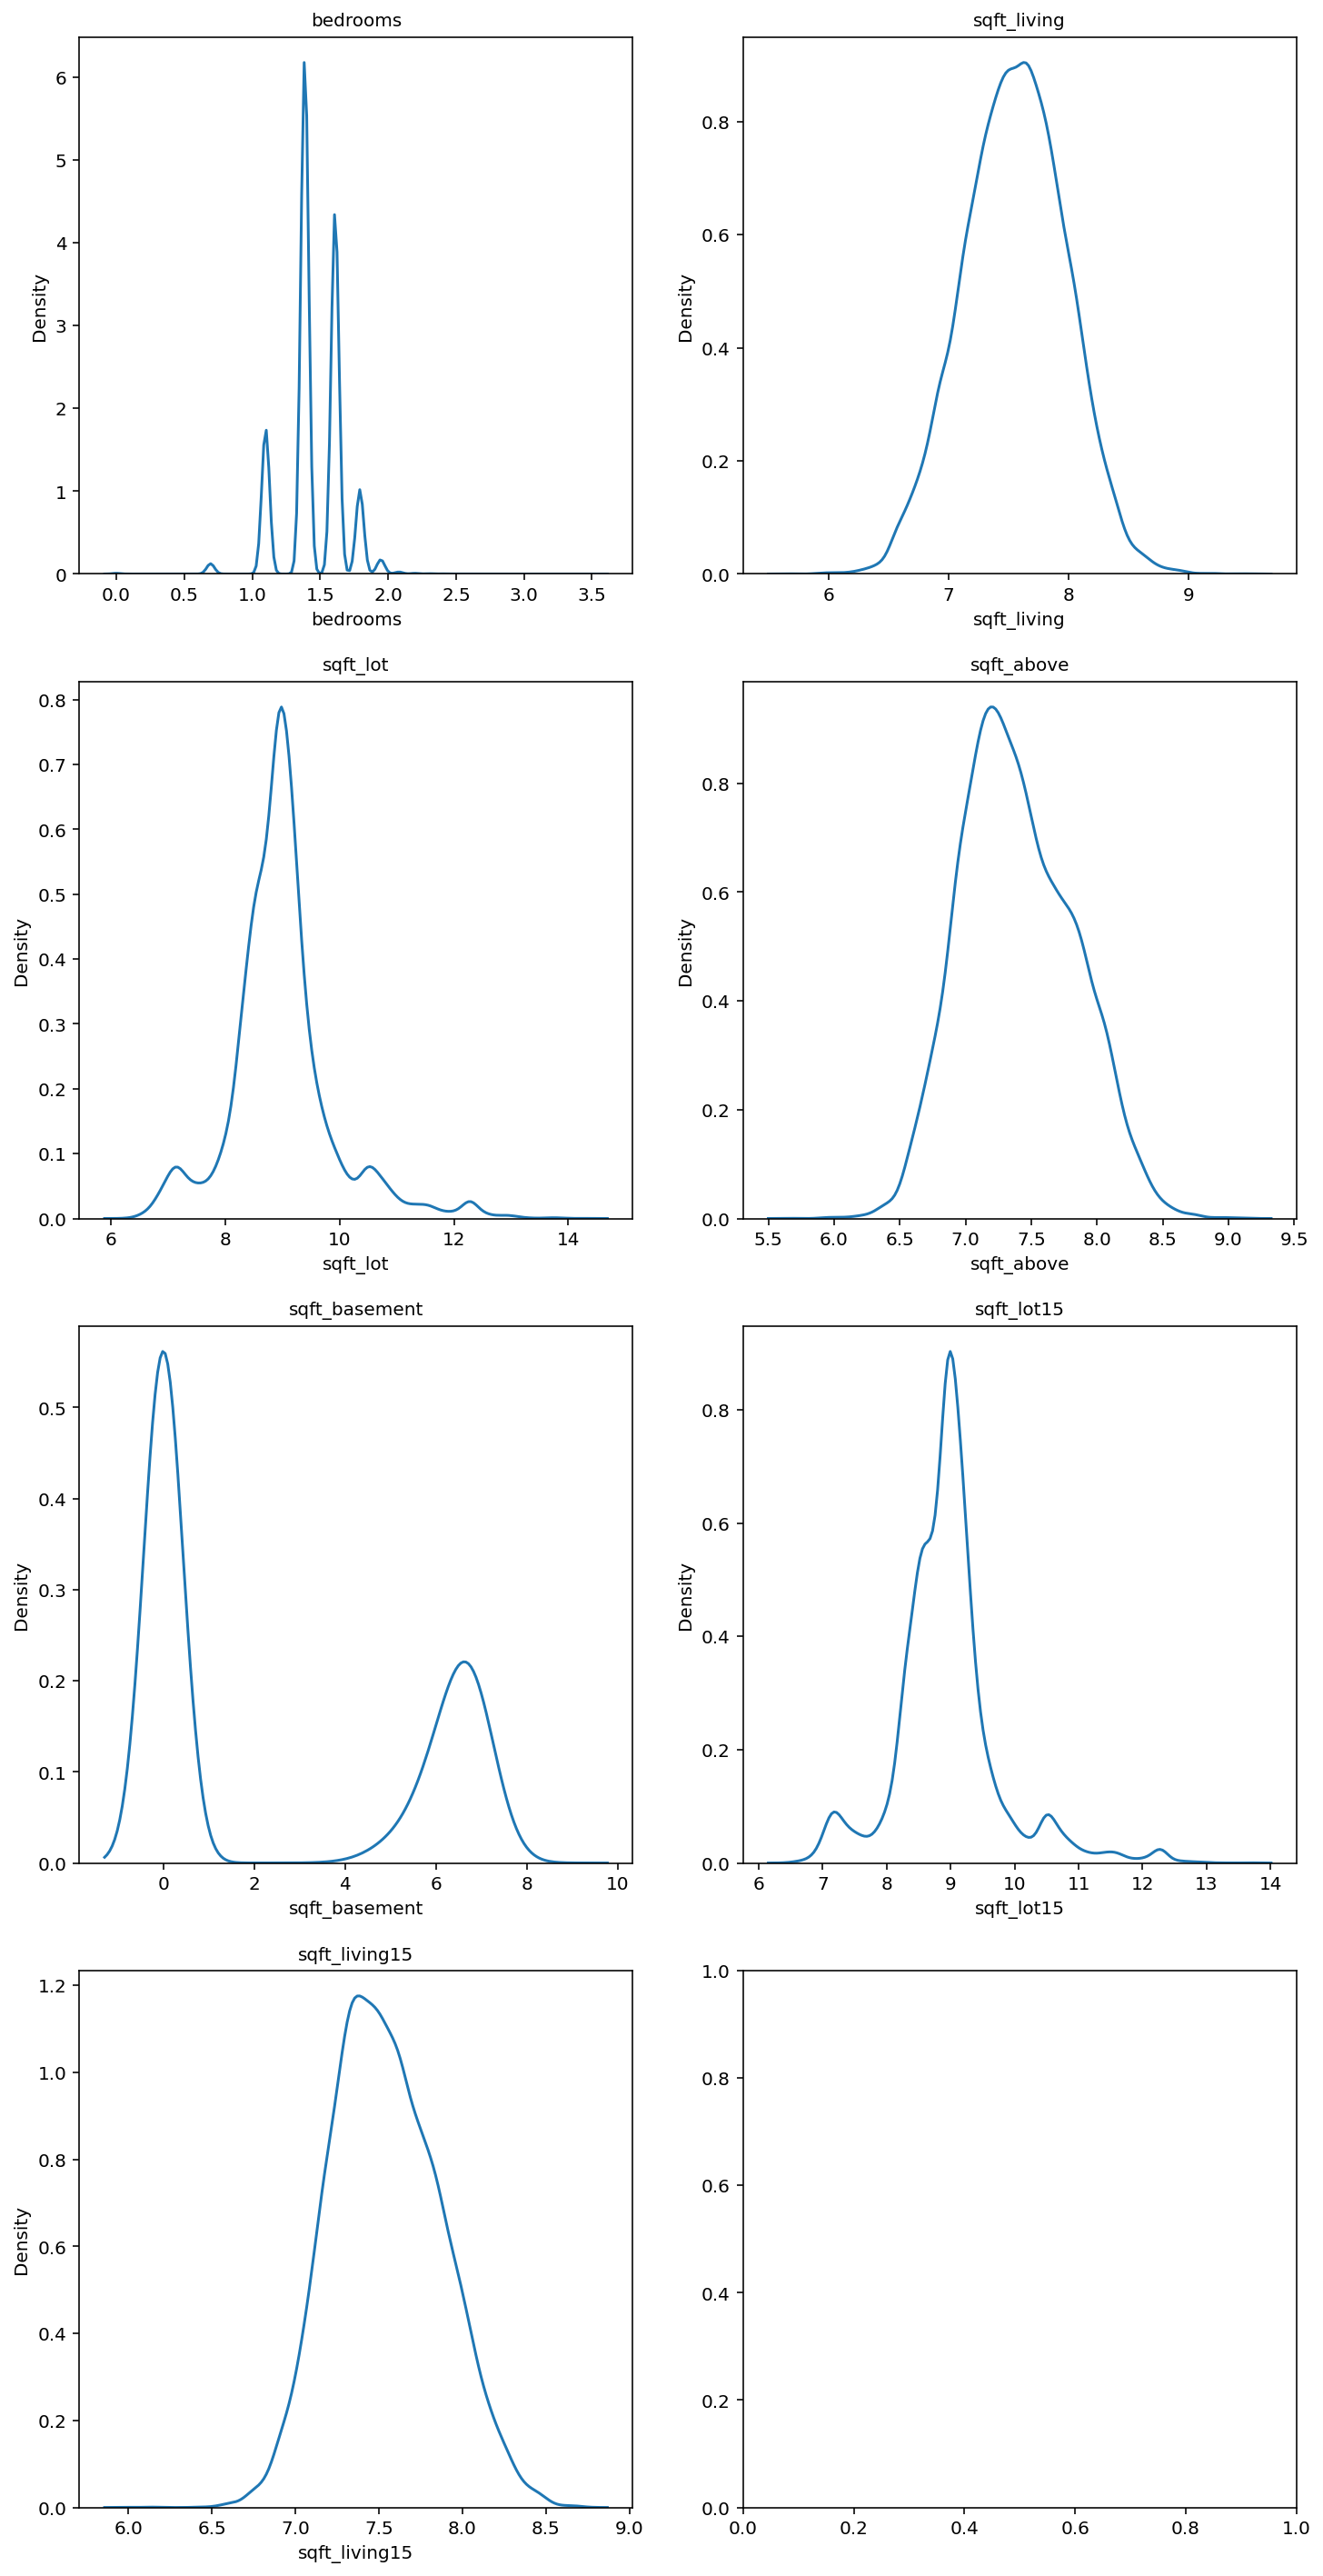

In [63]:
fig, ax = plt.subplots(4, 2, figsize=(12, 25))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 7 :
            break

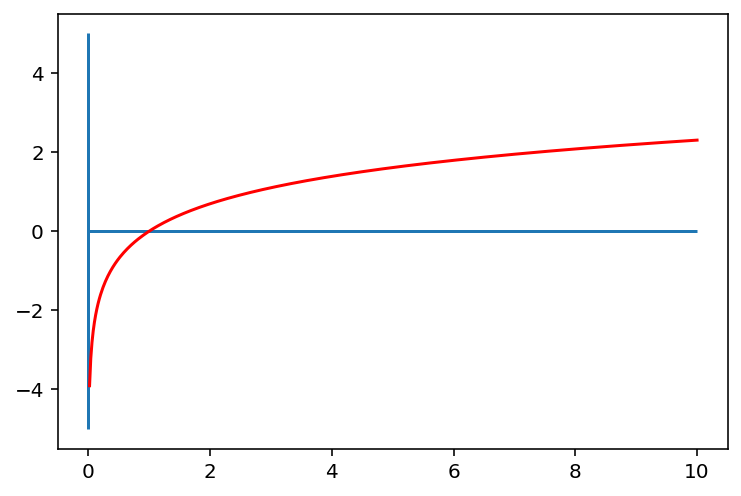

In [64]:
#로그함수의 형태 

xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

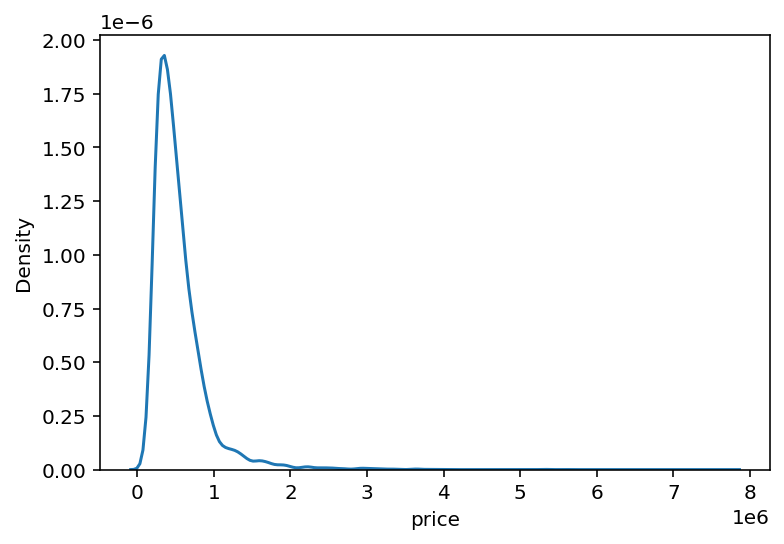

In [65]:
# 타겟 값 로그변환

#안했을때
sns.kdeplot(y)
plt.show()

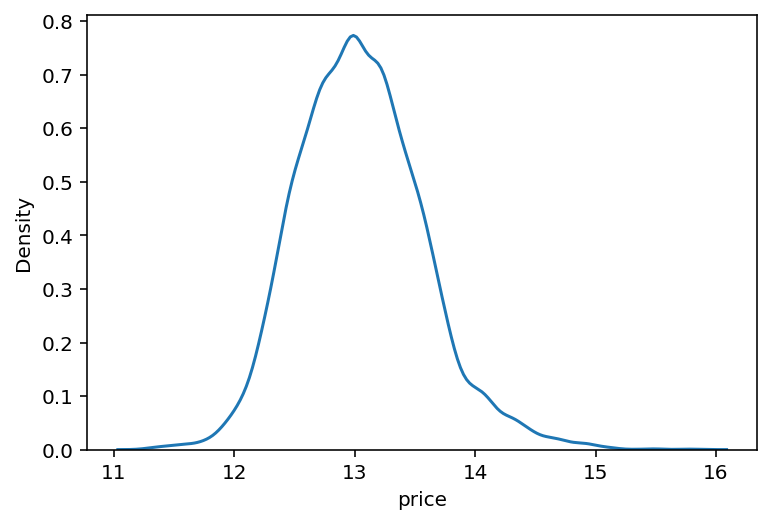

In [66]:
#했을 때
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [67]:
# 다시 train / test dataset으로 나누기

sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# 모델 설계 - 블렌딩(앙상블) 기법 사용


In [68]:
# 모델 선언

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [69]:
#average blending + cross validation 

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [70]:
# 모델 별 cv score
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8763
Model: LightGBM, CV score:0.8819


Baseline 모델에서는 다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수를 만들어 사용합니다. AveragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환합니다.

In [71]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [72]:
#예측값 생성

y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 548944.53804912,  443655.17105951, 1345797.07909443, ...,
        457185.23303678,  339532.04977609,  422564.70651683])

# 예측값 제출하기

In [73]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [74]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()


,id,price
0,15035,5.489445e+05
1,15036,4.436552e+05
2,15037,1.345797e+06
3,15038,3.206119e+05
4,15039,3.180479e+05


In [75]:
result.to_csv('submission1.csv', index =False)

# 하이퍼 파라미터 튜닝

## 데이터 전처리 

In [76]:
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [77]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [78]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [79]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [80]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [81]:
print(test.columns)
print('-----')
del test['id']
print(test.columns)


Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
-----
Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [82]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

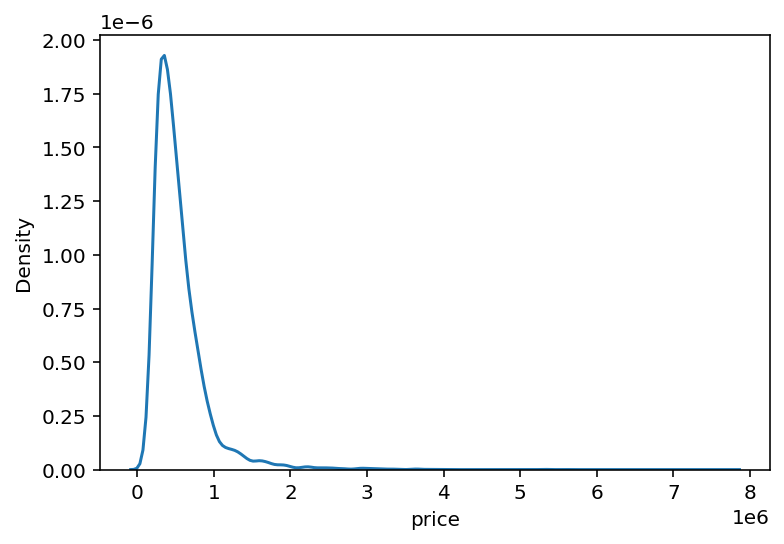

In [83]:
# 가격 데이터의 분포도
sns.kdeplot(y)
plt.show()

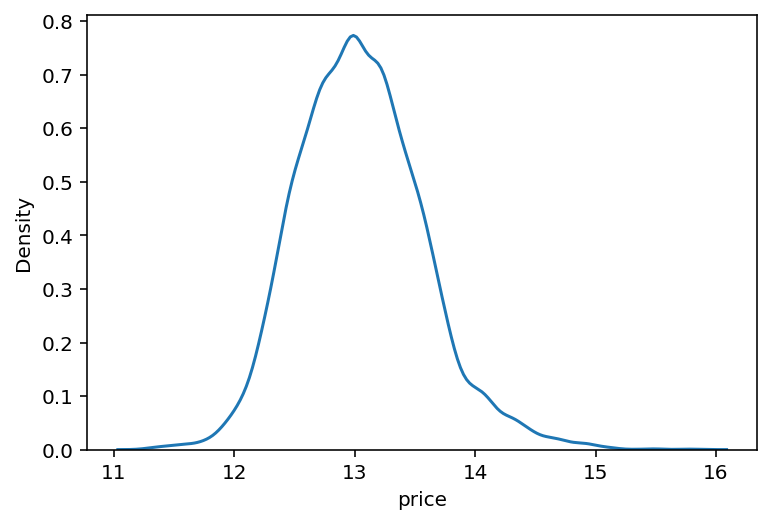

In [84]:
# price가 왼쪽으로 크게 치우쳐 있는 형태 -> 로그 변환을 해주고 모델이 값을 예측한 후에 다시 exp하여 되돌리기
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 모델 튜닝

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [87]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [88]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [89]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
        
    df[model_name] = rmse(y_test, y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 117618.22355411823,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

# XGBRegressor

# LGBMRegressor

이 두개가 성능이 좋아보이니 이 두개의 모델로 학습시켜보겠다!

In [4]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True, random_state=34) 

        # 모델 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_pred, y_test)
    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)


## 1. 그리드 탐색 

### 그리드 vs 랜덤 search

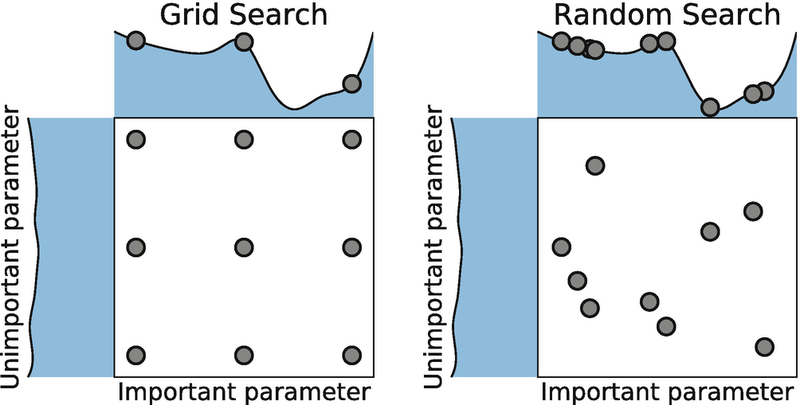

그리드탐색과 랜덤 탐색
- 그리드 탐색
    
    사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색. 
    
    특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리
    
    사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있음
    
    
- 랜덤 탐색

    사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법
    
    랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있음
    
    하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없음

In [91]:
from sklearn.model_selection import GridSearchCV

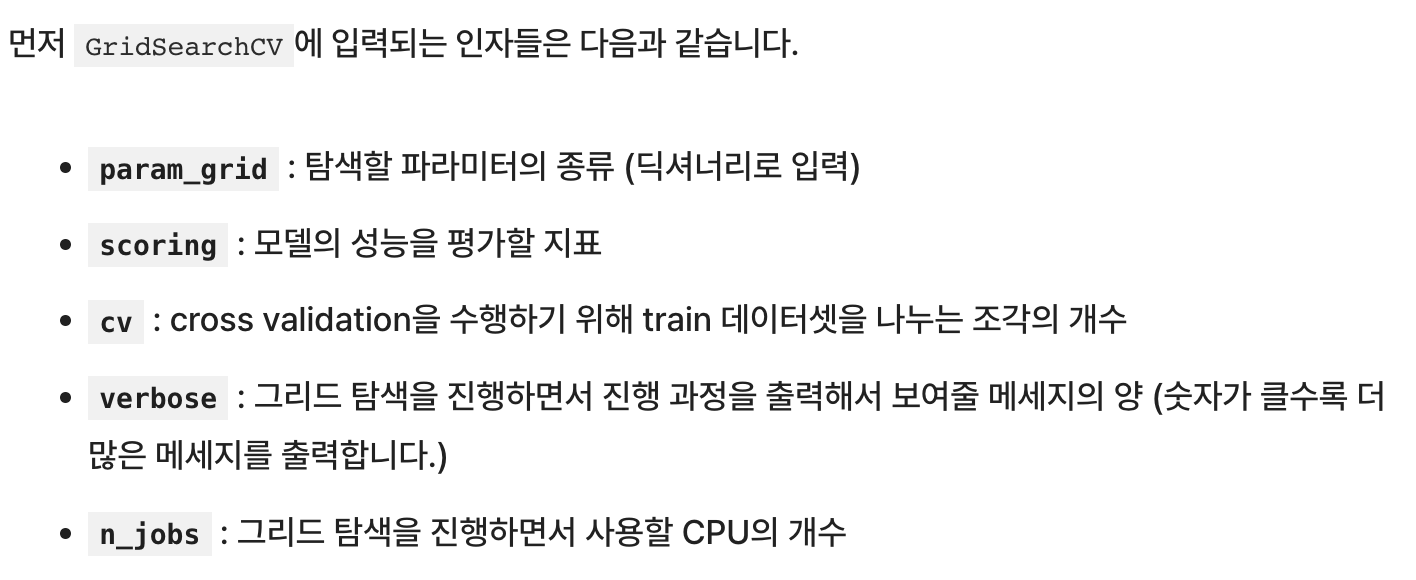


In [92]:
# !pip install --upgrade xgboost

In [93]:
# !pip install --upgrade scikit-learn

In [134]:
#딕셔너리형태
param_grid = {
    'n_estimators': [100, 1000, 10000],
    'max_depth': [1, 10, 100],
    'learning_rate' : [0.001, 0.01, 0.1, 1]
}

# XGBRegressor로 시도해보았지만, 학습시키는데 너무 오랜 시간이 걸려

# LGBMRegressor에 하이퍼파라미터를 수정하는 식으로 진행하기로 함

In [135]:
model = LGBMRegressor(random_state=random_state)

In [136]:
#gridsearchcv 실행순서 : 모델 초기화, 학습시키기 -> 모든 파라미터 조합의 실험
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=1)

grid_model.fit(train, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_depth': [1, 10, 100],
                         'n_estimators': [100, 1000, 10000]},
             scoring='neg_mean_squared_error', verbose=1)

In [137]:
# 그리드 서치 실험 결과

grid_model.cv_results_

{'mean_fit_time': array([ 0.12740765,  0.85927153,  8.17618723,  0.49319816,  4.78473425,
        39.563376  ,  0.48084507,  4.74475942, 40.57428727,  0.13231483,
         0.85350146,  8.14602213,  0.50683479,  3.99217882, 30.79148264,
         0.47541943,  4.24169722, 31.02125325,  0.12341123,  0.85522099,
         8.20859022,  0.42404842,  3.17919378, 28.50090551,  0.43567495,
         3.15664029, 29.01482353,  0.15400658,  0.85156436,  8.27608724,
         0.35657921,  3.13851695, 31.10986929,  0.3758327 ,  3.15952811,
        32.81545935]),
 'std_fit_time': array([0.01936307, 0.03244   , 0.05525359, 0.02032974, 0.18104584,
        1.36371382, 0.01516873, 0.18493636, 1.4672525 , 0.01571898,
        0.03458078, 0.10686987, 0.01152414, 0.04917484, 1.66277459,
        0.01806078, 0.17157886, 0.91373316, 0.01325596, 0.0414403 ,
        0.19448454, 0.01044974, 0.08539881, 0.3874568 , 0.02198859,
        0.02759768, 0.71492566, 0.03080973, 0.0387034 , 0.27930973,
        0.0186988 , 0.124

**파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장**

In [138]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']
print(params)
print()
print(score)

[{'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 100}, {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 1000}, {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 10000}, {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100}, {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 1000}, {'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 10000}, {'learning_rate': 0.001, 'max_depth': 100, 'n_estimators': 100}, {'learning_rate': 0.001, 'max_depth': 100, 'n_estimators': 1000}, {'learning_rate': 0.001, 'max_depth': 100, 'n_estimators': 10000}, {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}, {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 1000}, {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 10000}, {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}, {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}, {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10000}, {'learning_rate': 0.01, 'max_dept

In [139]:
param_df= pd.DataFrame(params)
param_df['score'] = score
param_df
# 데이터 프레임으로 출력하여 보기 편하게 함

,learning_rate,max_depth,n_estimators,score
0,0.001,1,100,-0.262146
1,0.001,1,1000,-0.166339
2,0.001,1,10000,-0.055875
3,0.001,10,100,-0.239401
4,0.001,10,1000,-0.081378
5,0.001,10,10000,-0.026723
6,0.001,100,100,-0.239401
7,0.001,100,1000,-0.081378
8,0.001,100,10000,-0.026682
9,0.010,1,100,-0.166044


## 점수는 왜 음수일까?
그 이유는 GridSearchCv을 초기화 할 때, scoring에 neg_mean_squared_error를 사용했기 때문에 점수가 음수로 표현

음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산을 해주면,

In [140]:
param_df['RMSE'] = np.sqrt(-1 * param_df['score'])
param_df

,learning_rate,max_depth,n_estimators,score,RMSE
0,0.001,1,100,-0.262146,0.512002
1,0.001,1,1000,-0.166339,0.407847
2,0.001,1,10000,-0.055875,0.236380
3,0.001,10,100,-0.239401,0.489286
4,0.001,10,1000,-0.081378,0.285269
5,0.001,10,10000,-0.026723,0.163473
6,0.001,100,100,-0.239401,0.489286
7,0.001,100,1000,-0.081378,0.285269
8,0.001,100,10000,-0.026682,0.163347
9,0.010,1,100,-0.166044,0.407484


## 아직도 위에서 보았던 10만 단위의 RMSE와는 다른 이유?

그 이유는 price에 있다.

위에서 우리는 price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했다

그 후 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이다.

따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 이다.

** log를 취한 값에서 RMSE를 구했다는 뜻

이에 맞게 컬럼의 이름을 RMSLE로 변환해 주면,

In [141]:
param_df = param_df.rename(columns={'RMSE': 'RMSLE'})
param_df

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.001,1,100,-0.262146,0.512002
1,0.001,1,1000,-0.166339,0.407847
2,0.001,1,10000,-0.055875,0.236380
3,0.001,10,100,-0.239401,0.489286
4,0.001,10,1000,-0.081378,0.285269
5,0.001,10,10000,-0.026723,0.163473
6,0.001,100,100,-0.239401,0.489286
7,0.001,100,1000,-0.081378,0.285269
8,0.001,100,10000,-0.026682,0.163347
9,0.010,1,100,-0.166044,0.407484


In [142]:
#RMSLE 오름차순 정렬

param_df.sort_values(by=['RMSLE'])

,learning_rate,max_depth,n_estimators,score,RMSLE
14,0.010,10,10000,-0.026217,0.161917
17,0.010,100,10000,-0.026265,0.162065
8,0.001,100,10000,-0.026682,0.163347
13,0.010,10,1000,-0.026687,0.163363
16,0.010,100,1000,-0.026690,0.163371
5,0.001,10,10000,-0.026723,0.163473
22,0.100,10,1000,-0.026739,0.163521
25,0.100,100,1000,-0.026767,0.163605
21,0.100,10,100,-0.027027,0.164399
24,0.100,100,100,-0.027051,0.164472


In [129]:
# """
# 다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

# 1. GridSearchCV 모델로 `model`을 초기화합니다.
# 2. 모델을 fitting 합니다.
# 3. params, score에 각 조합에 대한 결과를 저장합니다. 
# 4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
# """

# def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
#     # GridSearchCV 모델로 초기화
#     grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
#                               cv=5, verbose=verbose, n_jobs=n_jobs)

#     # 모델 fitting
#     grid_model.fit(train, y)

#     # 결과값 저장
#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']

#     # 데이터 프레임 생성
#     results = pd.DataFrame(params)
#     results['score'] = score

#     # RMSLE 값 계산 후 정렬
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')

#     return results

In [1]:
# #그리드탐색 실험 1

# param_grid = {
#     'n_estimators': [100, 1000, 10000],
#     'max_depth': [1, 10, 100],
#     'learning_rate' : [0.001, 0.01, 0.1, 1]
# }

# model = LGBMRegressor(random_state=random_state)
# my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=1)

In [143]:
model = LGBMRegressor(max_depth=10, n_estimators=10000, learning_rate = 0.01, random_state=random_state)
# 10, 1000, 0.01일 떄 가장 높았음 => XGBR
# 10, 10000, 0.01 일 때 가장 높았음 => LGBMR
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction

array([ 500556.87737587,  495682.76932437, 1250179.79750554, ...,
        482702.32737607,  324046.18094506,  436440.62729549])

In [144]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format( 'lgbm', '0.164')
submission.to_csv('submission3.csv', index = False)

In [85]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = data_dir
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format(model_name, round(rmsle,3))
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 그리드 서치를 위한 함수 정리

1. rmse 함수
2. rmse기준 스코어 모델 딕셔너리의 키값(모델마다) 기준으로 측정 -> 오름차순 정렬
3. 그리드서치를 적용한 2번과 같은 기능
4. 제출을 위한 함수

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [ ]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True, random_state=34) 

        # 모델 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
    
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_pred, y_test)
    
        # data frame에 저장
        df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)


In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = data_dir
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = 'submission_{}_RMSLE_{}.csv'.format(model_name, round(rmsle,3))
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 질문 list

1. 한 쪽으로 치우쳐진 분포를 어떤 기준으로 알 수 있는지 모호하다.
2. cv_score를 구할 때 모델이 학습이 이뤄지고 성능 평가가 되는 것인가? (v)


# 회고

배운점 : 하이퍼파라미터 수정하는 방법을 제대로 알지 못했는데 이번 기회에 개념을 다시 배울 수 있었습니다.

아쉬운 점 : 퍼블릭은 점수에 도달했으나 프라이빗이 점수까지 도달하지 못해 아쉬웠습니다.

느낀점 : 배운 것들을 활용해 다양하게 코드 수정하면서 시도해볼 수 있어 좋았습니다.

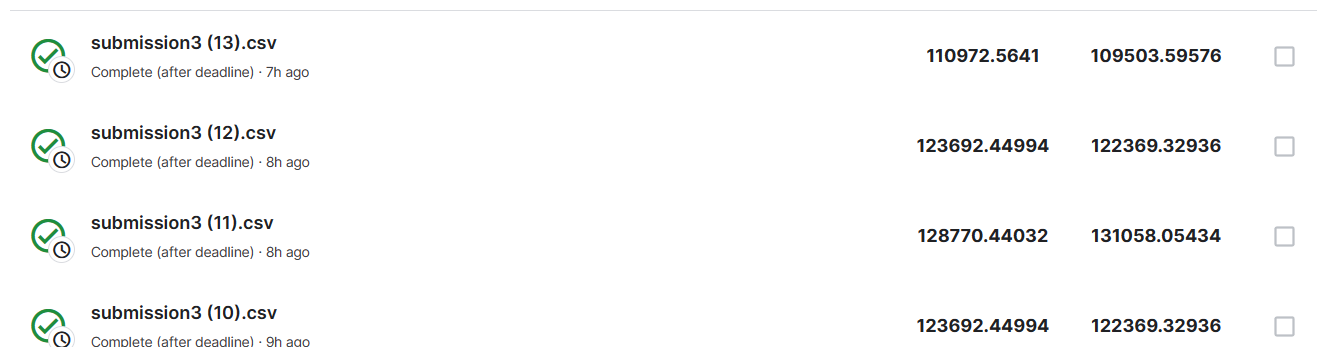